# Importing Libraries

In [50]:
import os, sys, random, shutil
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
from shutil import copyfile
import pandas as pd
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches
import numpy as np

Refer [this blog](https://towardsai.net/p/computer-vision/yolo-v5-object-detection-on-a-custom-dataset) for more information. Its an excellent resource.  
Tobacco 800 dataset could be downloaded from [here](http://tc11.cvc.uab.es/datasets/Tobacco800_1)

# Extracting information from Tobacco-800 XML files

In [131]:
df = []
cnt = 0

# refer the xml files to understand its structure and revist this code block.
annotations = sorted(glob('tobacco_data_zhugy/groundtruth/*.xml'))
for file in annotations:
    myroot = ET.parse(file).getroot()
    # image filename is changed aah97e00-page02_1.tif -> 0.tif, so the previous filename is collected here.
    prev_filename = myroot[0].attrib['src']
    filename = str(cnt) + '.tif' # new filename based on the count (0.tif, 1.tif etc)
    page_height, page_width =  myroot[0][0].attrib['height'], myroot[0][0].attrib['width']
    
    row = []
    # An image might have multiple items (zones) (logos and signs), so iterate through each zones
    for zone in myroot[0][0]:
        category = zone.attrib['gedi_type'] # type of zone (DLLogo/ DLSignature)
        id = zone.attrib['id']
        x, y = zone.attrib['col'], zone.attrib['row'] # x, y coordinate
        w, h = zone.attrib['width'], zone.attrib['height'] # width and height of bbox
        
        # Signature have Authors, represeting whose signature it is
        if category == 'DLSignature':
            AuthorID = zone.attrib['AuthorID']
            Overlapped = zone.attrib['Overlapped']
        else:
            # Logos don't have authors.
            AuthorID, Overlapped = ('NA', 'NA')
        row = [prev_filename, filename, page_height, page_width, AuthorID, Overlapped, category, id, x, y, w, h]
        df.append(row)
    cnt += 1

**Saving the information to Dataframe**

In [132]:
data = pd.DataFrame(df, columns=['prev_filename', 'filename', 'page_height', 'page_width', 'AuthorID', 'Overlapped', 'category', 'id', 'x', 'y', 'width', 'height'])

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height
0,aah97e00-page02_1.tif,0.tif,3296,2560,NA,NA,DLLogo,None,1074,18,374,219
1,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361
2,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183


In [64]:
test = data[['page_height', 'page_width']]
test.max(), test.min()

(page_height    3584.0
 page_width     2720.0
 dtype: float64,
 page_height    1575.0
 page_width     1200.0
 dtype: float64)

**Scaling the image to reduce training time**  
To save on training time, resize the images to a maximum height and width of 640 and 480. While resizing the image, the bounding box cordinates also changes. This code computes how much each image is shrinken and updates the bounding box coordinates appropriately.

In [138]:
BASE_DIR = 'tobacco_data_zhugy/pages/'
SAVE_PATH = 'tobacco_data_zhugy/scaled'
os.mkdir(SAVE_PATH)

def scale_image(df):
    df_new = []
    filename = df.prev_filename
    X, Y, W, H = map(int, df.x), map(int, df.y), map(int, df.width), map(int, df.height)
    for file, x, y, w, h in zip(filename, X, Y, W, H):
        image_path = BASE_DIR + file
        img = cv2.imread(image_path, 1)
        page_height, page_width = img.shape[:2]
        max_height = 640
        max_width = 480
        
        # computes the scaling factor
        if max_height < page_height or max_width < page_width:
            scaling_factor = max_height / float(page_height)
            if max_width/float(page_width) < scaling_factor:
                scaling_factor = max_width / float(page_width)
            # scale the image with the scaling factor
            img = cv2.resize(img, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)
        jpg_filename = file[:-4] + '.jpg'
        new_file_path = SAVE_PATH + jpg_filename
        cv2.imwrite(new_file_path, img) # write the scales image
        
        # save new page height and width
        page_height, page_width = page_height*scaling_factor, page_width*scaling_factor
        # compute new x, y, w, h coordinates after scaling
        x, y, w, h= int(x*scaling_factor), int(y*scaling_factor), int(w*scaling_factor), int(h*scaling_factor)
        row = [jpg_filename, x, y, w, h, page_height, page_width]
        df_new.append(row)
    return df_new
scaled_data = scale_image(data)

**Adding the information regarding the scaling to the df**

In [140]:
scaled_data = list(zip(*scaled_data))

data['new_filename'] = scaled_data[0]
data['x_scaled'] = scaled_data[1]
data['y_scaled'] = scaled_data[2]
data['w_scaled'] = scaled_data[3]
data['h_scaled'] = scaled_data[4]
data['page_height_scaled'] = scaled_data[5]
data['page_width_scaled'] = scaled_data[6]
data.head(10)

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height,new_filename,x_scaled,y_scaled,w_scaled,h_scaled,page_height_scaled,page_width_scaled
0,aah97e00-page02_1.tif,0.tif,3296,2560,NA,NA,DLLogo,None,1074,18,374,219,aah97e00-page02_1.jpg,201,3,70,41,618.000000,480.0
1,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361,aah97e00-page02_2.jpg,264,148,123,67,618.000000,480.0
2,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183,aam09c00.jpg,228,395,210,50,636.666667,480.0
3,aao54e00_2.tif,4.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206,aao54e00_2.jpg,283,132,117,38,618.000000,480.0
4,abm69c00.tif,5.tif,2292,1728,"Feldman, J.D.",Yes,DLSignature,None,667,1279,617,110,abm69c00.jpg,185,355,171,30,636.666667,480.0
5,acr64d00.tif,6.tif,2292,1728,"Boffa, J.R.",Yes,DLSignature,None,886,1801,463,181,acr64d00.jpg,246,500,128,50,636.666667,480.0
6,adh36e00-page2_1.tif,7.tif,3245,2560,NA,NA,DLLogo,None,1181,18,359,219,adh36e00-page2_1.jpg,221,3,67,41,608.437500,480.0
7,adh36e00-page2_2.tif,8.tif,3246,2560,"Krivisky, B.M.",Yes,DLSignature,None,1232,2399,896,431,adh36e00-page2_2.jpg,231,449,168,80,608.625000,480.0
8,adh36e00_1.tif,9.tif,3245,2560,NA,NA,DLLogo,None,1187,18,347,219,adh36e00_1.jpg,222,3,65,41,608.437500,480.0
9,adh36e00_2.tif,10.tif,3246,2560,"Krivisky, B.M.",Yes,DLSignature,None,1239,2403,889,434,adh36e00_2.jpg,232,450,166,81,608.625000,480.0


**Testing the scaled image**

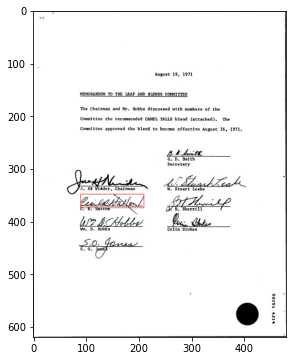

In [141]:
img = cv2.imread('tobacco_data_zhugy/scaled/agw39d00.jpg')

img = cv2.rectangle(img, (90, 348), (90+120, 348+26), (255, 0, 0), 1)
plt.figure(figsize=(6, 6))
plt.imshow(img)

**Saving to CSV file**

In [145]:
data[['prev_filename', 'new_filename', 'filename', 'page_height', 'page_width', 'page_height_scaled', 'page_width_scaled', 'AuthorID', 'Overlapped', 'category', 'id', 'x', 'y', 'width', 'height', 'x_scaled', 'y_scaled', 'w_scaled', 'h_scaled']].to_csv('tobacco_data_zhugy/tobacco_cleaned.csv', index=False)
data.head(3)

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height,new_filename,x_scaled,y_scaled,w_scaled,h_scaled,page_height_scaled,page_width_scaled
0,aah97e00-page02_1.tif,0.tif,3296,2560,NA,NA,DLLogo,None,1074,18,374,219,aah97e00-page02_1.jpg,201,3,70,41,618.000000,480.0
1,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361,aah97e00-page02_2.jpg,264,148,123,67,618.000000,480.0
2,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183,aam09c00.jpg,228,395,210,50,636.666667,480.0


# Converting data to YOLOv5 format

In [150]:
def x_center(df):
  return int(df.x_scaled + (df.w_scaled/2))
def y_center(df):
  return int(df.y_scaled + (df.h_scaled/2))

def w_norm(df, col):
  return df[col]/df['page_width_scaled']
def h_norm(df, col):
  return df[col]/df['page_height_scaled']

df = pd.read_csv('tobacco_data_zhugy/tobacco_cleaned.csv')

le = preprocessing.LabelEncoder()
le.fit(df['category'])
print(le.classes_)
labels = le.transform(df['category'])
df['labels'] = labels


df['x_center'] = df.apply(x_center, axis=1)
df['y_center'] = df.apply(y_center, axis=1)

df['x_center_norm'] = df.apply(w_norm, col='x_center',axis=1)
df['width_norm'] = df.apply(w_norm, col='w_scaled', axis=1)

df['y_center_norm'] = df.apply(h_norm, col='y_center',axis=1)
df['height_norm'] = df.apply(h_norm, col='h_scaled',axis=1)

df.head(1)

['DLLogo' 'DLSignature']


,prev_filename,new_filename,filename,page_height,page_width,page_height_scaled,page_width_scaled,AuthorID,Overlapped,category,...,y_scaled,w_scaled,h_scaled,labels,x_center,y_center,x_center_norm,width_norm,y_center_norm,height_norm
0,aah97e00-page02_1.tif,aah97e00-page02_1.jpg,0.tif,3296,2560,618.0,480.0,NaN,NaN,DLLogo,...,3,70,41,0,236,23,0.491667,0.145833,0.037217,0.066343


# Moving images to train and valid folders

In [152]:
df_train, df_valid = model_selection.train_test_split(df, test_size=0.1, random_state=13, shuffle=True)
print(df_train.shape, df_valid.shape)

(1207, 26) (135, 26)


**Creating relevant directories**

In [156]:
os.mkdir('tobacco_data_zhugy/tobacco_yolo_format/')
os.mkdir('tobacco_data_zhugy/tobacco_yolo_format/images/')
os.mkdir('tobacco_data_zhugy/tobacco_yolo_format/images/train/')
os.mkdir('tobacco_data_zhugy/tobacco_yolo_format/images/valid/')

os.mkdir('tobacco_data_zhugy/tobacco_yolo_format/labels/')
os.mkdir('tobacco_data_zhugy/tobacco_yolo_format/labels/train/')
os.mkdir('tobacco_data_zhugy/tobacco_yolo_format/labels/valid/')

**Segregating images and labels to train and valid**

In [160]:
def segregate_data(df, img_path, label_path, train_img_path, train_label_path):
  filenames = []
  for filename in df.filename:
    filenames.append(filename)
  filenames = set(filenames)
  
  for filename in filenames:
    yolo_list = []

    for _,row in df[df.filename == filename].iterrows():
      yolo_list.append([row.labels, row.x_center_norm, row.y_center_norm, row.width_norm, row.height_norm])

    yolo_list = np.array(yolo_list)
    txt_filename = os.path.join(train_label_path,str(row.new_filename.split('.')[0])+".txt")
    # Save the .img & .txt files to the corresponding train and validation folders
    np.savetxt(txt_filename, yolo_list, fmt=["%d", "%f", "%f", "%f", "%f"])
    shutil.copyfile(os.path.join(img_path,row.new_filename), os.path.join(train_img_path,row.new_filename))
 
# Apply function
src_img_path = "tobacco_data_zhugy/scaled/"
src_label_path = "tobacco_data_zhugy/groundtruth/"

train_img_path = "tobacco_data_zhugy/tobacco_yolo_format/images/train"
train_label_path = "tobacco_data_zhugy/tobacco_yolo_format/labels/train"

valid_img_path = "tobacco_data_zhugy/tobacco_yolo_format/images/valid"
valid_label_path = "tobacco_data_zhugy/tobacco_yolo_format/labels/valid"

segregate_data(df_train, src_img_path, src_label_path, train_img_path, train_label_path)
segregate_data(df_valid, src_img_path, src_label_path, valid_img_path, valid_label_path)

print("No. of Training images", len(os.listdir('tobacco_data_zhugy/tobacco_yolo_format/images/train')))
print("No. of Training labels", len(os.listdir('tobacco_data_zhugy/tobacco_yolo_format/labels/train')))

print("No. of valid images", len(os.listdir('tobacco_data_zhugy/tobacco_yolo_format/images/valid')))
print("No. of valid labels", len(os.listdir('tobacco_data_zhugy/tobacco_yolo_format/labels/valid')))

No. of Training images 807
No. of Training labels 807
No. of valid images 129
No. of valid labels 129


**Deleting ipython checkpoints**

In [161]:
try:
  shutil.rmtree('tobacco_data_zhugy/tobacco_yolo_format/images/train/.ipynb_checkpoints')
except FileNotFoundError:
  pass

try:
  shutil.rmtree('tobacco_data_zhugy/tobacco_yolo_format/images/valid/.ipynb_checkpoints')
except FileNotFoundError:
  pass

try:
  shutil.rmtree('tobacco_data_zhugy/tobacco_yolo_format/labels/train/.ipynb_checkpoints')
except FileNotFoundError:
  pass

try:
  shutil.rmtree('tobacco_data_zhugy/tobacco_yolo_format/labels/valid/.ipynb_checkpoints')
except FileNotFoundError:
  pass
